## Now that I have figured out how to install XGBoost as well as run it cleanly, this notebook will be a cleaned-up version of the previous notebook. I'm going to take out all of the exploratory stuff and go straight to the heart of the matter. I'm also going to clean up the imports, test and train data frames as well as the null columns using the train data set. Go line by line and make sure everything is straightforward and decently commented. 

## Well, after running into yet more problems with xgboost and how it has handled this dataset, I found a more relevant kernel on kaggle that has a clean way of creating the model. This notebook will combine the successful aspects of my earlier efforts with that kernel in hopes of at least generating a submission.. Cross your fingers!

In [1]:
#The usual imports..
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns           # Makes prettier plots
from sklearn import model_selection, preprocessing
import xgboost as xgb
import time                     # Using time to check how long it takes to train model

In [2]:
train_df = pd.read_csv('./data/train.csv', parse_dates=['timestamp'])
test_df = pd.read_csv('./data/test.csv', parse_dates=['timestamp'])

In [3]:
print(train_df.shape)
print(test_df.shape)
print(test_df.columns)
print(train_df.columns)

(30471, 292)
(7662, 291)
Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000'],
      dtype='object', length=291)
Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)


In [4]:
train_df.isnull().sum()

id                                           0
timestamp                                    0
full_sq                                      0
life_sq                                   6383
floor                                      167
max_floor                                 9572
material                                  9572
build_year                               13605
num_room                                  9572
kitch_sq                                  9572
state                                    13559
product_type                                 0
sub_area                                     0
area_m                                       0
raion_popul                                  0
green_zone_part                              0
indust_part                                  0
children_preschool                           0
preschool_quota                           6688
preschool_education_centers_raion            0
children_school                              0
school_quota 

In [5]:
train_df = train_df.fillna(train_df.mean())
train_df.isnull().sum()

id                                       0
timestamp                                0
full_sq                                  0
life_sq                                  0
floor                                    0
max_floor                                0
material                                 0
build_year                               0
num_room                                 0
kitch_sq                                 0
state                                    0
product_type                             0
sub_area                                 0
area_m                                   0
raion_popul                              0
green_zone_part                          0
indust_part                              0
children_preschool                       0
preschool_quota                          0
preschool_education_centers_raion        0
children_school                          0
school_quota                             0
school_education_centers_raion           0
school_educ

In [6]:
#test_df[test_df.isnull()].dtypes
train_df['product_type'].value_counts()

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [7]:
# We see that there is roughly an even split between investment and owneroccupier in the training data.
# I'll fill the test data frame missing values with "Investment" and move forward
test_df['product_type'].fillna('Investment', inplace=True)

In [8]:
for col in test_df.columns:
    if test_df[col].isnull().sum() != 0:
        test_df[col] = test_df[col].fillna(train_df[col].mean())
test_df.isnull().sum()

id                                       0
timestamp                                0
full_sq                                  0
life_sq                                  0
floor                                    0
max_floor                                0
material                                 0
build_year                               0
num_room                                 0
kitch_sq                                 0
state                                    0
product_type                             0
sub_area                                 0
area_m                                   0
raion_popul                              0
green_zone_part                          0
indust_part                              0
children_preschool                       0
preschool_quota                          0
preschool_education_centers_raion        0
children_school                          0
school_quota                             0
school_education_centers_raion           0
school_educ

### Well, it looks like I took care of the null values in the test dataframe. All I had to do was sort out the product_type column, it seems. I'll take it! 

In [9]:
#Further cleaning of the data sets, and setting up some variables for later use. 
target = 'price_doc'
IDcol = 'id'
timestamp = 'timestamp'
y_train = train_df[target]
X_train = train_df.drop([IDcol, timestamp, target], axis=1)
X_test = test_df.drop([IDcol, timestamp], axis=1)

In [10]:
# This method of encoding categorical data seems to be much cleaner than my previous method of one-hot encoding..
for c in X_train.columns:
    if X_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[c].values))
        X_train[c] = lbl.transform(list(X_train[c].values))
for c in X_test.columns:
    if X_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_test[c].values))
        X_test[c] = lbl.transform(list(X_test[c].values))

In [11]:
# Set up the parameter dictionary for xgboost
params = {
    'eta': 0.05,
    'objective': 'reg:linear',
    'max_depth': 5,
    'eval_metric': 'rmse',
    'updater': 'grow_gpu',
    'silent': 1,
    'subsample':0.7,
    'colsample_bytree':0.7
}
# Create the data matrices for XGBoost
dtrain = xgb.DMatrix(X_train, y_train)
dtest =xgb.DMatrix(X_test)

### Well, so far, so good. This new kernel involves the use of the cv method from xgboost. I'm going to incorporate that (mostly since it creates another cool chart), and see how it goes. 

[0]	train-rmse:8.22175e+06	test-rmse:8.22701e+06
[50]	train-rmse:2.93644e+06	test-rmse:3.25981e+06
[100]	train-rmse:3.84093e+06	test-rmse:4.1334e+06


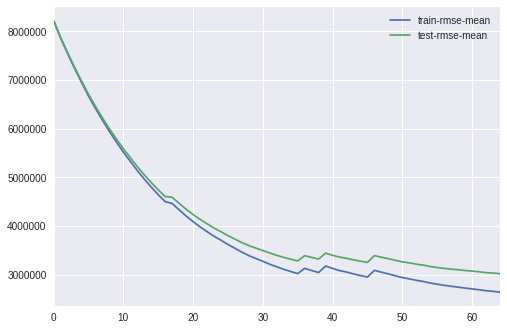

In [12]:
cv_output = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=50, verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

### Well... It works so far! I'm extremely (Xtremely?!) excited about this. Nothing like a little Data Science-ing at 7 in the morning! Now to move on to training the model, and creating a submission. After a little parameter tuning, of course.. Oi.

In [13]:
num_round = len(cv_output)
tmp = time.time()
bst = xgb.train(dict(params, silent=0), dtrain, num_round)
boost_time = time.time() - tmp
print('Train time: %s sec' % (str(boost_time)))

Train time: 2.635956048965454 sec


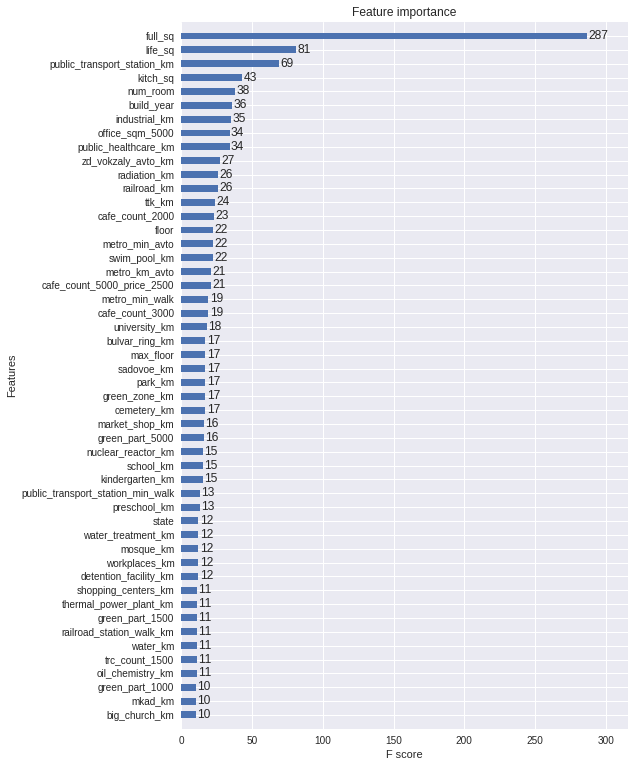

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,13))
xgb.plot_importance(bst, max_num_features=50, height=0.5, ax=ax)

In [16]:
test_id = test_df['id'].astype('int32') # grab the id column from the test set
preds = bst.predict(dtest)
output = pd.DataFrame({'id':test_id, 'price_doc': preds})
output.head()

,id,price_doc
0,30474,5201769.5
1,30475,7708331.5
2,30476,5365227.0
3,30477,5328482.5
4,30478,4887486.0


In [18]:
output.dtypes

id             int32
price_doc    float32
dtype: object

In [19]:
preds.min()

-6785298.5

### Ah ha, well apparently, my model will return negative values. I'm not sure how or why that's possible, but it is. I'm going to be super lazy and just take the absolute value. 

In [20]:
output = output.abs()

In [21]:
output.describe()

,id,price_doc
count,7662.000000,7.662000e+03
mean,34304.500000,7.100008e+06
std,2211.973214,3.478223e+06
min,30474.000000,1.209260e+05
25%,32389.250000,5.151784e+06
50%,34304.500000,6.253415e+06
75%,36219.750000,7.983087e+06
max,38135.000000,5.254649e+07


In [ ]:
output['price_doc'][1]

In [22]:
output.to_csv('CN_XGB_submit.csv', index=False)

# I finally finished this silly, silly project! It took a few weeks (one week in earnest), but I defintely learned a lot along the way. Not only about how to work with XGBoost, but how to learn a new prediction model by searching the internet for tips, tricks, and examples. I don't even care if my model is really crappy. I'm just glad it's done! 